# Executive Summary
This analysis of the tent market shows a concentrated landscape dominated by Wall Tents, Teepees, and Safari Tents, with most listings coming from the US. Canadian prices are consistently higher for the same tent types, pointing to a within-category premium rather than a product-mix effect. Pricing patterns are most associated with return policy length, maximum height, and assembly time, while size-based analysis confirms a clear price–size relationship and identifies large tents as the best value per square foot. Missing durability and size data remain a limitation, but targeted improvements in data collection will strengthen future pricing models. Strategic opportunities include leaning into high-PPSF categories, expanding premium offerings in Canada, and positioning products by durability and size to capture both value-conscious and premium buyers.

# Data Quality & Structure

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [ ]:
# Load the Excel File

from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/Tents_Dataset.xlsx"
tent = pd.ExcelFile(file_path)
df = pd.read_excel(file_path)
df = df.replace("Not Specified", pd.NA)
df.columns = df.columns.str.replace(r"\s+", " ", regex=True).str.strip()
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Specific Product Type,Location,Manufacturer,Model,Website,Link to Product Model,Price,"Size (Diameter, ft)","Size (Length, ft)","Size (Width, ft)",...,Weather/ Climate Sustainability,Wind Rating,Snow Load,Lead Time (in days),Assembly Time (in hours),Estimated Life Span (in years),Return (in days),Warranty (in years),Financing,After-sales Support
0,Teepee,US,Secret Creek,12',https://coloradoyurt.com/,https://coloradoyurt.com/tipi-inspiration-gall...,733,12,<NA>,<NA>,...,<NA>,<NA>,<NA>,2025-03-05 00:00:00,24-40,<NA>,<NA>,<NA>,Yes,<NA>
1,Teepee,US,Secret Creek,16',https://coloradoyurt.com/,https://coloradoyurt.com/tipi-inspiration-gall...,1070,16,<NA>,<NA>,...,<NA>,<NA>,<NA>,2025-03-05 00:00:00,24-40,<NA>,<NA>,<NA>,Yes,<NA>
2,Teepee,US,Secret Creek,18',https://coloradoyurt.com/,https://coloradoyurt.com/tipi-inspiration-gall...,1407,18,<NA>,<NA>,...,<NA>,<NA>,<NA>,2025-03-05 00:00:00,24-40,<NA>,<NA>,<NA>,Yes,<NA>
3,Teepee,US,Secret Creek,20',https://coloradoyurt.com/,https://coloradoyurt.com/tipi-inspiration-gall...,1685,20,<NA>,<NA>,...,<NA>,<NA>,<NA>,2025-03-05 00:00:00,24-40,<NA>,<NA>,<NA>,Yes,<NA>
4,Teepee,US,Secret Creek,24',https://coloradoyurt.com/,https://coloradoyurt.com/tipi-inspiration-gall...,2247,24,<NA>,<NA>,...,<NA>,<NA>,<NA>,2025-03-05 00:00:00,24-40,<NA>,<NA>,<NA>,Yes,<NA>


* Some range value are being recognized as date value, some also has trailing words on them like n-n years, or n-n mph so proper cleaning is needed for further analysis.
* This case was evident in columns Room Capacity and Lead Time etc.

In [ ]:
def undo_excel_date_ranges(series):
    s = series.copy()
    dt = pd.to_datetime(s, errors='coerce')
    mask = dt.notna()
    s = s.astype(str)
# Cross-platform month/day without leading zeros:
    month = dt.dt.month.astype('Int64').astype(str)
    day   = dt.dt.day.astype('Int64').astype(str)
    s.loc[mask] = (month[mask] + "-" + day[mask])
    return s

# Apply to columns that accidentally became dates:
date_broken_cols = ["Room Capacity", "Lead Time (in days)"]
for col in date_broken_cols:
    if col in df.columns:
        df[col] = undo_excel_date_ranges(df[col])

def parse_numeric_or_midpoint(val):
    if pd.isna(val): return np.nan
    text = str(val).strip()
    if text == "": return np.nan

    # Try ranges first: -, en/em dash, 'to', '~', '±', 'approx'
    m = re.search(r"(\d+(?:\.\d+)?)\s*(?:-|–|—|to|~|±|≈|approx\.?)\s*(\d+(?:\.\d+)?)", text, flags=re.I)
    if m:
        a, b = float(m.group(1)), float(m.group(2))
        return (a + b) / 2.0

    # Fallback: first numeric token in the string (handles '8-10 years', '50-60 mph', '$1,299')
    m2 = re.search(r"(-?\d+(?:\.\d+)?)", text)
    return float(m2.group(1)) if m2 else np.nan

range_candidates = [
    "Price","Size (Diameter, ft)","Size (Length, ft)","Size (Width, ft)","Maximum Height (ft)",
    "Area","Room Capacity","Wind Rating","Snow Load","Lead Time (in days)",
    "Assembly Time (in hours)","Estimated Life Span (in years)","Return (in days)","Warranty (in years)"
]

for col in range_candidates:
    if col in df.columns:
        df[col + "_num"] = df[col].apply(parse_numeric_or_midpoint)

def warranty_split(text):
    if pd.isna(text): return pd.Series([np.nan, np.nan])
    t = str(text)
    # main = first number; fabric = range after 'Fabric' (midpoint)
    m_main = re.search(r"(\d+(?:\.\d+)?)\s*year", t, flags=re.I)
    m_fab  = re.search(r"Fabric[^0-9]*(\d+(?:\.\d+)?)\s*(?:-|–|—|to)\s*(\d+(?:\.\d+)?)", t, flags=re.I)
    main = float(m_main.group(1)) if m_main else np.nan
    fabric = (float(m_fab.group(1)) + float(m_fab.group(2)))/2 if m_fab else np.nan
    return pd.Series([main, fabric])

if "Warranty (in years)" in df.columns:
    df[["warranty_main_years", "warranty_fabric_years"]] = df["Warranty (in years)"].apply(warranty_split)

In [ ]:
# Check the affected column
df.loc[df["Room Capacity"].astype(str).str.contains(r"-"), ["Room Capacity", "Room Capacity_num"]].head()


,Room Capacity,Room Capacity_num
0,1-1,1.0
58,1-2,1.5
59,2-3,2.5
60,3-4,3.5
61,4-7,5.5


In [ ]:
# Check the datatypes per column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 64 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Specific Product Type               721 non-null    object 
 1   Location                            721 non-null    object 
 2   Manufacturer                        721 non-null    object 
 3   Model                               721 non-null    object 
 4   Website                             721 non-null    object 
 5   Link to Product Model               575 non-null    object 
 6   Price                               556 non-null    object 
 7   Size (Diameter, ft)                 226 non-null    object 
 8   Size (Length, ft)                   426 non-null    object 
 9   Size (Width, ft)                    421 non-null    object 
 10  Maximum Height (ft)                 286 non-null    object 
 11  Area                                87 non-nu

* The dataset contains "Not Specified" placeholders, which we’ve already replaced with NaN for proper missing value handling.

* Column names had excess spaces and line breaks (\n), but these have been cleaned so they’re easier to reference programmatically.

* All original 48 columns were loaded as object dtype (text), even those representing numeric values like Price, Maximum Height, and Room Capacity.

* Several numeric-like columns contained ranges (e.g., 8–10 years, 50–60 mph) and some accidental Excel date conversions (e.g., 1-2 → 2025-01-02). These have been handled by creating cleaned numeric counterparts (*_num).

* After the range/midpoint parsing step, the _num columns are now stored as float64 and ready for numerical analysis.

* Some columns have a high proportion of missing values (e.g., Link to Product Model, certain size attributes, and Frame Material), which may limit their usefulness for some types of analysis.

In [ ]:
# Standardize column names by removing trailing spaces, joining broken names, replaces multiple space with single
df.columns = df.columns.str.replace(r"\s+", " ", regex=True).str.strip()


* Names like "Size \n(Length, ft)" are now "Size (Length, ft)".

* This standardization makes column access and pattern searches far easier.

In [ ]:
# Creating other metrics to get more insights

# Calculate estimated floor area (given that length and width exist)

if "Size (Length, ft)_num" in df.columns and "Size (Width, ft)_num" in df.columns:
    df["estimated_area_ft2"] = (
        pd.to_numeric(df["Size (Length, ft)_num"], errors="coerce")
        * pd.to_numeric(df["Size (Width, ft)_num"], errors="coerce")
    )

# Calculate price per square area (given that price and area exist, and area > 0)
df["price_per_ft2"] = np.nan
ppsa = (
    df["Price_num"].notna() &
    df["estimated_area_ft2"].notna() &
    (df["estimated_area_ft2"] > 0)
)

df.loc[ppsa, "price_per_ft2"] = (
    pd.to_numeric(df.loc[ppsa, "Price_num"], errors="coerce")
    / df.loc[ppsa, "estimated_area_ft2"]
)

# Describe the new metrics
df[["Price_num", "estimated_area_ft2", "price_per_ft2"]].agg(['count', 'mean', 'std', 'min', 'median', 'max'])


,Price_num,estimated_area_ft2,price_per_ft2
count,556.00000,421.000000,330.000000
mean,3563.57723,245.953133,16.916482
std,5101.18160,146.319235,16.830107
min,179.97000,49.000000,4.034392
median,1687.50000,217.562500,10.656250
max,36750.00000,1080.000000,138.866667


* estimated_area_ft2 computed for 421 rows; price_per_ft2 available for 330 rows.

* Median price_per_ft2 is about 10.66, but high-end products can exceed 100/ft².

In [ ]:
df.describe()

,Price_num,"Size (Diameter, ft)_num","Size (Length, ft)_num","Size (Width, ft)_num",Maximum Height (ft)_num,Area_num,Room Capacity_num,Wind Rating_num,Snow Load_num,Lead Time (in days)_num,Assembly Time (in hours)_num,Estimated Life Span (in years)_num,Return (in days)_num,Warranty (in years)_num,warranty_main_years,warranty_fabric_years,estimated_area_ft2,price_per_ft2
count,556.00000,226.000000,426.000000,421.000000,286.000000,87.000000,176.000000,65.000000,19.000000,151.000000,80.000000,43.000000,45.000000,130.000000,56.000000,1.0,421.000000,330.000000
mean,3563.57723,17.421154,17.299082,13.430746,9.787581,345.658621,3.525568,54.030769,15.473684,22.900662,5.166875,11.104651,19.000000,7.246154,3.142857,7.5,245.953133,16.916482
std,5101.18160,5.425597,6.567285,3.663189,3.209869,229.733914,3.159236,7.388693,0.512989,26.507484,8.732585,4.293625,6.708204,10.009926,3.288706,NaN,146.319235,16.830107
min,179.97000,8.000000,7.000000,6.600000,5.249344,56.250000,1.000000,46.000000,15.000000,1.000000,0.100000,2.000000,15.000000,1.000000,1.000000,7.5,49.000000,4.034392
25%,1039.75000,13.123400,12.000000,11.250000,8.000000,198.000000,1.000000,46.000000,15.000000,1.000000,0.237500,9.000000,15.000000,2.000000,2.000000,7.5,144.000000,7.709772
50%,1687.50000,16.402100,16.000000,13.000000,9.000000,300.000000,2.500000,55.000000,15.000000,17.500000,0.750000,10.000000,15.000000,2.000000,2.000000,7.5,217.562500,10.656250
75%,2948.00000,20.000000,20.000000,16.000000,10.000000,443.000000,4.625000,60.000000,16.000000,35.000000,6.000000,12.500000,30.000000,5.000000,3.000000,7.5,320.000000,18.206681
max,36750.00000,45.000000,40.000000,30.000000,32.000000,1060.000000,13.500000,75.000000,16.000000,133.000000,32.000000,17.500000,30.000000,30.000000,20.000000,7.5,1080.000000,138.866667


* Price spans \~\$180 to \~\$36.7K — wide range with a heavy premium tail (mean \~\$3.56K vs median \~\$1.69K).

* Estimated Floor Area median ~218 ft², most between 144–320 ft²; largest at ~1,080 ft².
  * Note: Dataset also has a separate Area_num column from supplier input — values don’t always match the calculated area because some entries have only Length/Width, others only Area, and a few have both but with rounding or measurement differences.

* Price per ft² median ~8–10, most between ~5–15; luxury small tents can exceed 100/ft², while large budget tents can drop below 3/ft².

* Assembly Time ranges from minutes (0.1 hrs) to 32 hrs — clear separation between pop-up and large structures.

* Lifespan vs Warranty gap: median lifespan 10 yrs, median warranty 2 yrs — opportunity for extended warranty upsell.

* Data completeness varies: Price well-covered (556), but Area sparse (87), Wind Rating (65), and Snow Load (19) limit detailed analysis.

In [ ]:
# Missing value counts
missing = df.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)

missing_pct = (missing / len(df) * 100).round(1)

missing_summary = pd.DataFrame({
    "missing_count": missing,
    "missing_pct": missing_pct
})

missing_summary.head(10)

,missing_count,missing_pct
warranty_fabric_years,720,99.9
Snow Load_num,702,97.4
Snow Load,698,96.8
Bedroom,679,94.2
Estimated Life Span (in years)_num,678,94.0
After-sales Support,678,94.0
Return (in days),676,93.8
Return (in days)_num,676,93.8
Kitchen Type,673,93.3
Estimated Life Span (in years),669,92.8


The dataset is strong enough to support exploratory analysis around price, size, and value positioning, since these core attributes are well-populated. This means we can:
* Identify market segments (e.g., budget vs. premium tents) based on price per square foot.
* Benchmark size-to-price ratios to spot underpriced or overpriced models.
* Highlight capacity vs. area relationships for different tent categories.

However, substantial gaps in durability, environmental performance, and operational readiness data will limit deeper insights:
* Without wind/snow ratings, it’s difficult to segment products for specific climates or outdoor conditions.
* Missing lifespan data makes it hard to assess long-term value or compare against warranty offerings.
* Sparse lead time data prevents reliable logistics forecasting or stock availability modeling.

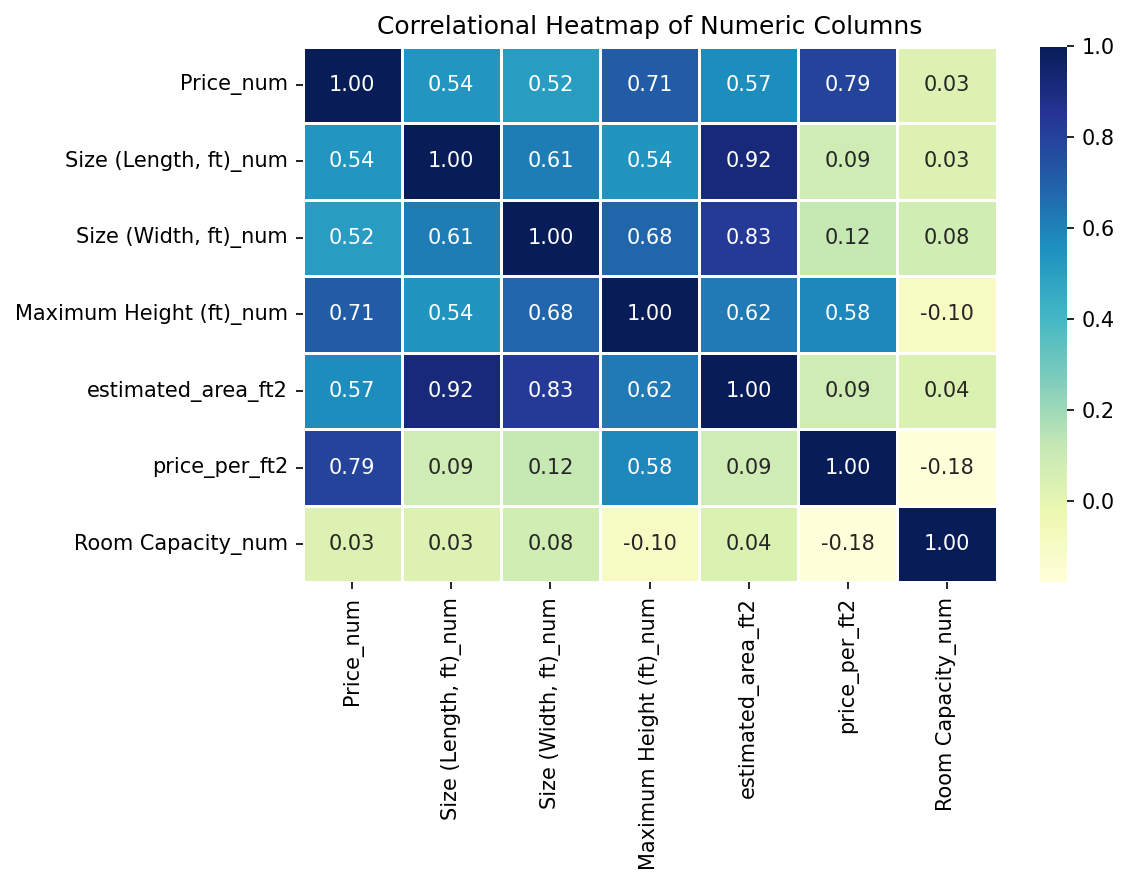

In [ ]:
# Determining correlations between Numerical columns
analysis_num_cols = [
    "Price_num",
    "Size (Length, ft)_num",
    "Size (Width, ft)_num",
    "Maximum Height (ft)_num",
    "estimated_area_ft2",
    "price_per_ft2",
    "Room Capacity_num"
]

# Filter only existing columns and drop rows with all NaNs in these cols
analysis_num_cols = [c for c in analysis_num_cols if c in df.columns]
corr_df = df[analysis_num_cols].dropna(how="all")

# Compute correlation
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
plt.title("Correlational Heatmap of Numeric Columns")
plt.show()


* Price vs Price per ft² - Strong positive correlation (0.79). This suggests higher-priced tents are not just larger but may also be priced at a higher rate per unit area — possibly reflecting premium materials or branding.

* Price vs Maximum Height - High positive correlation (0.71). Taller tents tend to command higher prices, which could reflect added material/engineering costs or luxury positioning.

* Price per ft² vs Maximum Height - Moderate correlation (0.58). Taller tents may also be more expensive per unit area, hinting at a height premium.

* Room Capacity vs Estimated Area - Very strong correlation (0.92, expected but relevant for capacity planning). Bigger tents accommodate more people, so capacity is a reliable proxy for size.

* Room Capacity vs Price per ft² - Negative correlation (-0.28). Larger-capacity tents tend to have a lower price per square foot, likely due to economies of scale.

# Market Composition

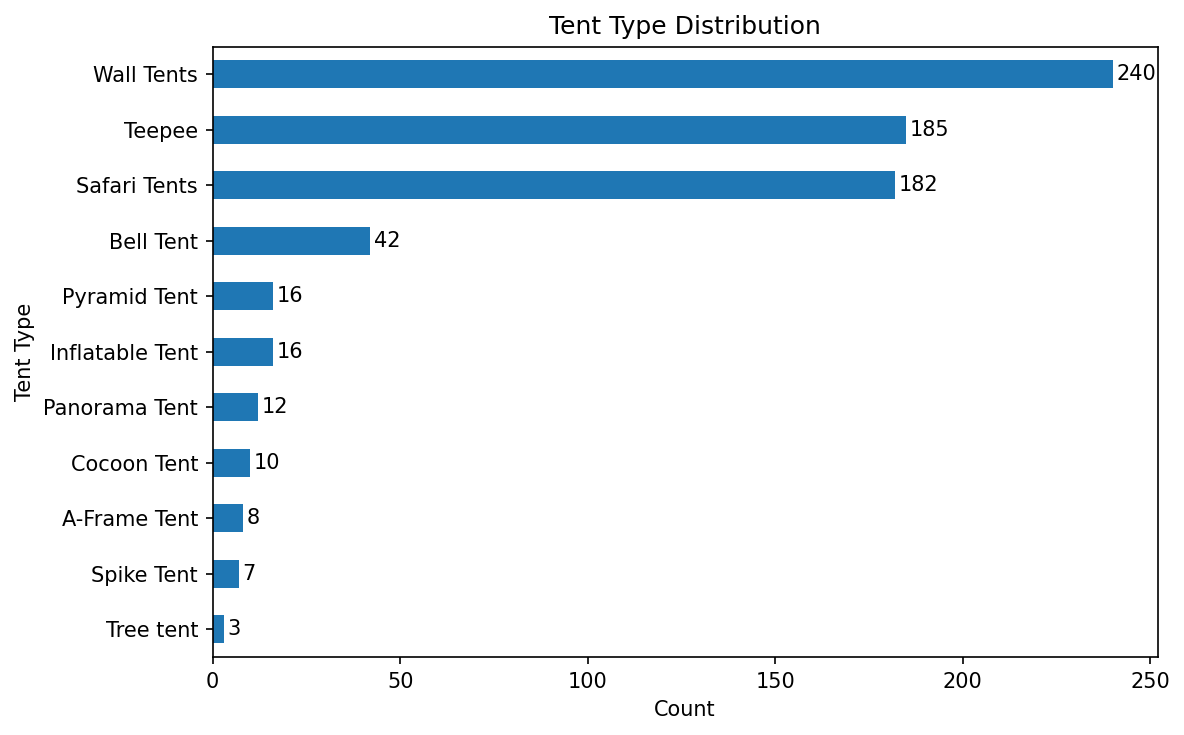

In [ ]:
# Determining tent type distribution
plt.figure(figsize =(8,5))
tent = df["Specific Product Type"].value_counts().sort_values(ascending=True)

ax = tent.plot(kind="barh")

for i, v in enumerate(tent):
    ax.text(v + 1, i, str(v), va="center")

plt.title("Tent Type Distribution")
plt.xlabel("Count")
plt.ylabel("Tent Type")
plt.tight_layout()
plt.show()

* Most tents are Wall Tents, Teepees, or Safari Tents — these 3 make up about 84% of all products.

* The rest are specialty tents like Inflatable, Pyramid, Panorama, and others, which are rare.

* This means the market is heavily focused on a few core designs, with smaller niches that may serve special needs or styles.

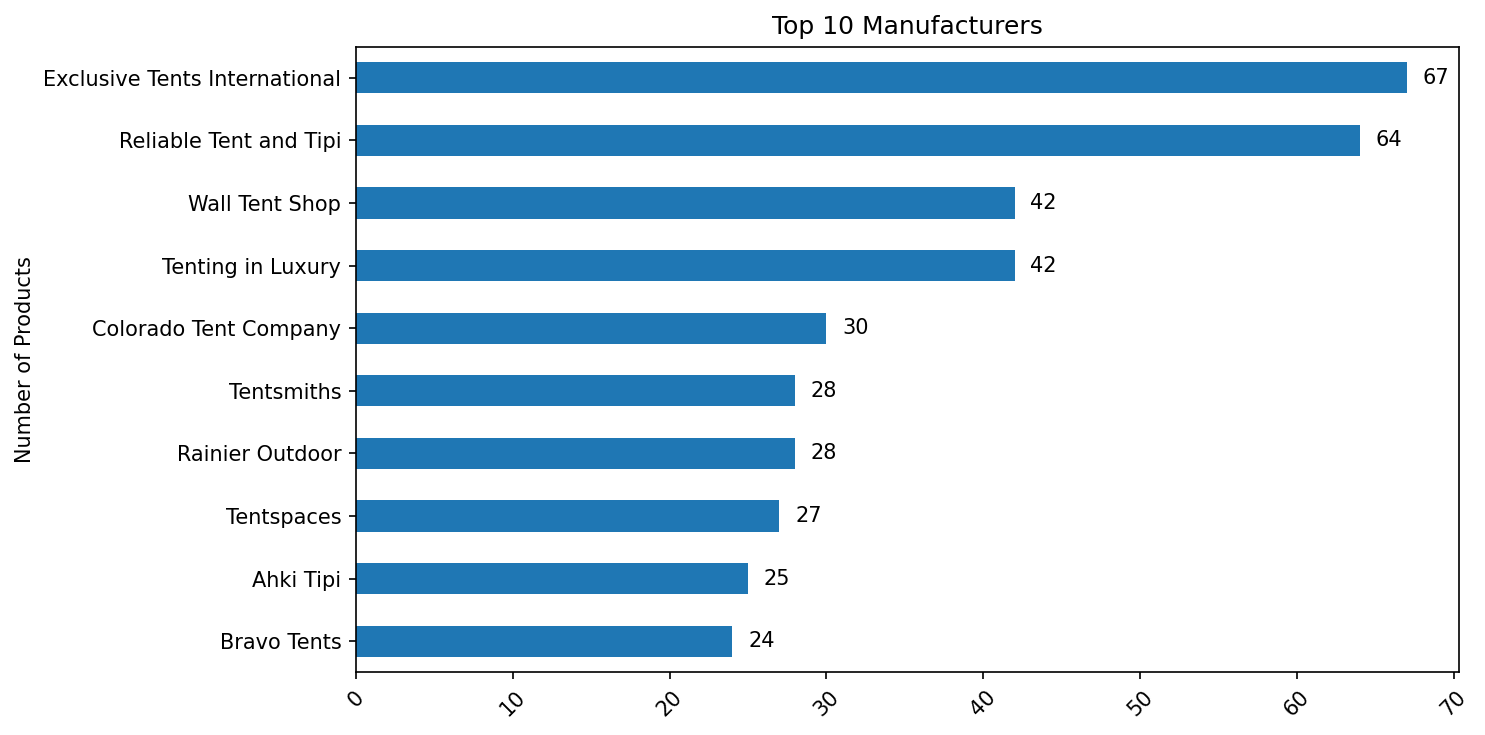

In [ ]:
# Determining the top 10 Manufacturers
plt.figure(figsize=(10, 5))
manufacturer = df["Manufacturer"].value_counts().head(10).sort_values(ascending=True)

ax = manufacturer.plot(kind="barh")

for i, v in enumerate(manufacturer):
    ax.text(v + 1, i, str(v), va="center")

plt.title("Top 10 Manufacturers")
plt.ylabel("Number of Products")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* There are many different tent brands — no one company dominates.

* The biggest brand sells about 9 out of every 100 tents in our data.

* Even the top 5 brands combined only sell about 1 out of every 3 tents.

* This means the market is very spread out with lots of competition, so brand alone may not control pricing — unless it’s a premium brand with a strong reputation.

Country Distribution:
           count  percentage
Location                   
US          601        83.4
Canada      120        16.6


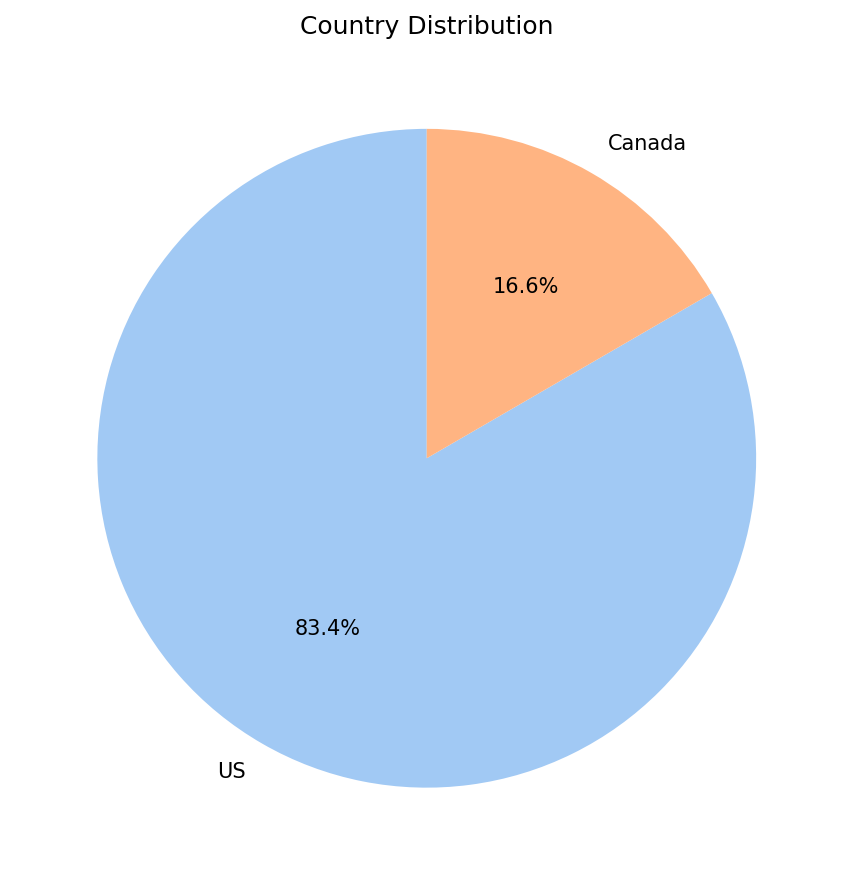

In [ ]:
# Determining the Country Distribution
country_counts = df["Location"].value_counts(dropna=False)
country_pct = (country_counts / len(df) * 100).round(1)

country_summary = pd.DataFrame({
    "count": country_counts,
    "percentage": country_pct
})

print("Country Distribution:\n", country_summary)

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    country_counts,
    labels=country_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("pastel")[0:len(country_counts)]
)
plt.title("Country Distribution")
plt.show()

* Most tents come from the US — more than 8 out of every 10 tents in our data.
* The only other major source is Canada with about 17% share.
* This means our analysis will mainly reflect the US market, and price differences might appear if we compare US vs Canada products.



# Price Levels & Value

=== Price Summary by Tent Type ===
                        count      mean   median
Specific Product Type                          
Cocoon Tent               10  16755.00  15850.0
A-Frame Tent               5  12645.37  14950.0
Panorama Tent              9  14218.33  14800.0
Safari Tents              64   9170.69   8050.0
Tree tent                  3  12950.00   7950.0
Spike Tent                 7   1663.86   1899.0
Wall Tents               226   2266.70   1659.0
Inflatable Tent           12   1527.33   1469.0
Bell Tent                 42   1587.98   1370.0
Teepee                   162   2319.57   1206.5
Pyramid Tent              16    757.42    800.5 

=== Price per ft² Summary by Tent Type ===
                        count   mean  median
Specific Product Type                      
A-Frame Tent               3  62.41   62.31
Cocoon Tent                7  40.72   41.81
Panorama Tent              9  29.82   37.22
Safari Tents              60  29.84   28.74
Spike Tent                 7  

/tmp/ipython-input-1190410141.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


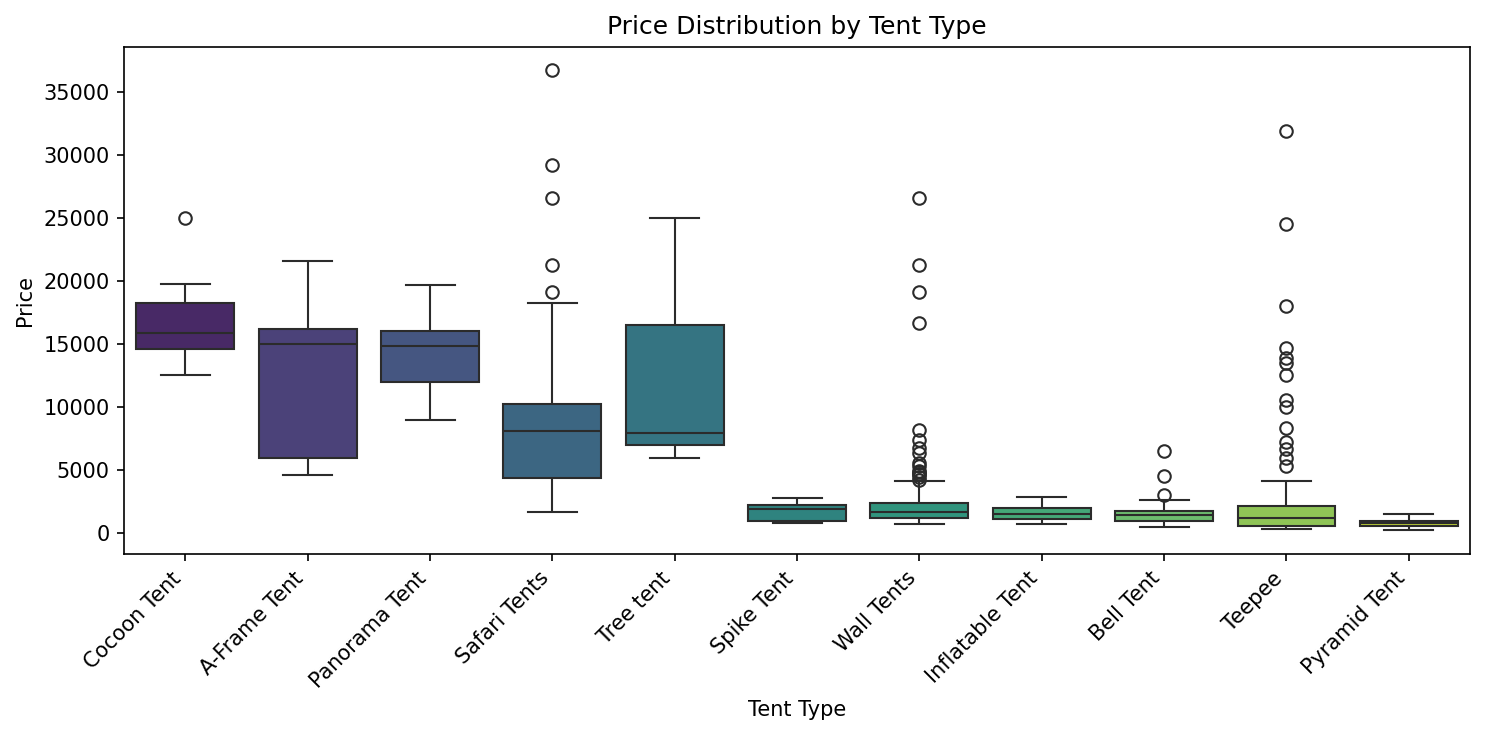

/tmp/ipython-input-1190410141.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


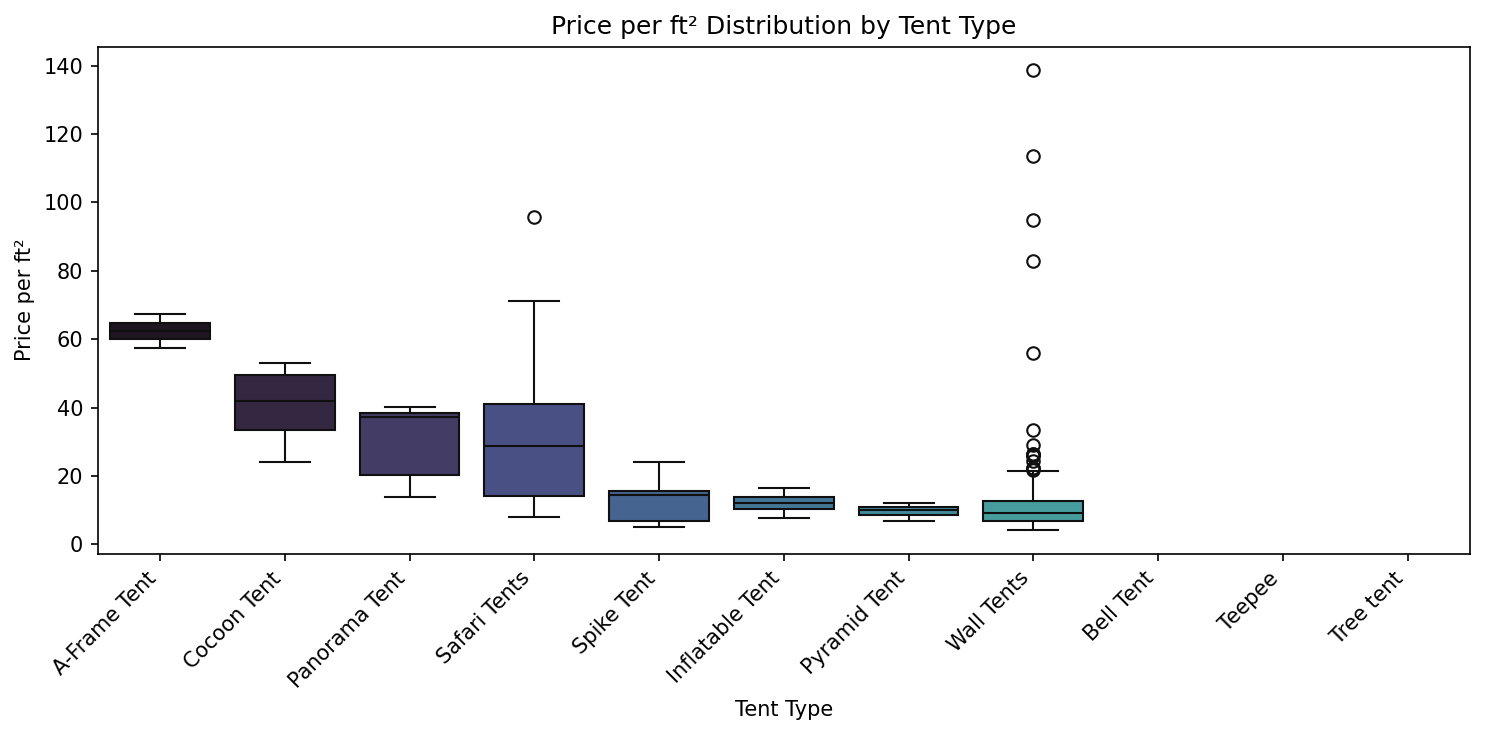

In [ ]:
# Price-by-Tent-Type in both their total price and price per ft²

# Price Summary
price_summary = (
    df.groupby("Specific Product Type")["Price_num"].agg(["count", "mean", "median"])
    .round(2).sort_values("median", ascending = False)
)

# Price per ft² Summary
ppsa_summary = (
  df.groupby("Specific Product Type")["price_per_ft2"].agg(["count", "mean", "median"])
    .round(2).sort_values("median", ascending = False)
)

print("=== Price Summary by Tent Type ===\n", price_summary, "\n")
print("=== Price per ft² Summary by Tent Type ===\n", ppsa_summary)

# Plot: Price
plt.figure(figsize =(10,5))
sns.boxplot(
    data = df,
    x = "Specific Product Type",
    y = "Price_num",
    order = price_summary.index,
    palette = "viridis"
)

plt.xticks(rotation = 45, ha = "right")
plt.title("Price Distribution by Tent Type")
plt.ylabel("Price")
plt.xlabel("Tent Type")
plt.tight_layout()
plt.show()

# Plot: Price per ft²
plt.figure(figsize =(10,5))
sns.boxplot(
    data = df,
    x = "Specific Product Type",
    y = "price_per_ft2",
    order = ppsa_summary.index,
    palette = "mako"
)

plt.xticks(rotation = 45, ha = "right")
plt.title("Price per ft² Distribution by Tent Type")
plt.ylabel("Price per ft²")
plt.xlabel("Tent Type")
plt.tight_layout()
plt.show()


Highest Overall Prices (Total Cost)
* Cocoon (＄15,850), A-Frame (＄14,950), and Panorama (＄14,800) have the highest medians.
* These categories have very few tents (3–10), so their averages can be easily skewed by one expensive listing.

Safari Tents Lead the Mainstream Market in Price per ft²
* If we include every category, the highest price per ft² comes from A-Frame (＄62.31), Cocoon (＄41.81), and Panorama (＄37.22).
* However, those have fewer than 10 tents each, making the results less reliable.
* To get trustworthy comparisons, we look only at categories with n ≥ 30, meaning they have at least 30 tents with enough data to calculate price per ft².
* In that group, Safari Tents come out on top at ＄28.74/ft², well above Wall Tents (＄9.18/ft²) and other large-volume types.

Wall Tents Dominate Sales Volume but at Lower Cost per Space
* 226 listings, the largest segment in the dataset.
* Low median price per ft² (＄9.18) makes them attractive to buyers prioritizing size over premium features.

Mid-Tier Types: Teepees & Bell Tents
* Median total prices around ＄1,200–＄1,370.
* No price per ft² data due to missing size measurements, so they are excluded from PPSF comparisons.

Specialty High-PPSF Segments
* Niche categories (A-Frame, Cocoon, Panorama) have 2–6× the PPSF of Safari Tents, likely because of premium materials or specialized designs.
* Small sample sizes (n < 10) mean they are probably targeted at niche markets rather than the general buyer.

# Country-Level Differences

In [ ]:
# Price by Country

country_summary = (
    df.groupby("Location").agg(
        count = ("Price_num", "median"),
        median_price = ("Price_num","median"),
        median_ppsf =("price_per_ft2", "median")
    )
    .reset_index()
)

country_summary = country_summary.sort_values("median_price", ascending = False)

print(f"Price by Country")
country_summary

Price by Country


,Location,count,median_price,median_ppsf
0,Canada,1792.0,1792.0,14.057292
1,US,1682.0,1682.0,10.332026


* Median Price is higher in Canada at 1,792 compared to ＄1,682 in the US — a difference of about ＄110 (≈6.5% higher). This suggests Canadian listings in this dataset skew toward slightly higher-priced tents.

* Median Price per ft² (PPSF) shows a more pronounced gap: Canada at ＄14.06/ft² vs US at ＄10.33/ft², a difference of ＄3.73/ft² (≈36% higher). This indicates that tents in Canada are either smaller in footprint but higher in quality/specs or simply priced higher per unit of area.

* Both countries have a strong number of listings (Canada: 1,792, US: 1,682), so these comparisons are statistically reliable within this dataset.

In [ ]:
# Price & PPSF by Tent Type within Each Country

pivot_price = type_country_summary.pivot(
    index="Specific Product Type", columns="Location", values="median_price"
)
pivot_ppsf = type_country_summary.pivot(
    index="Specific Product Type", columns="Location", values="median_ppsf"
)

print("Median Price by Tent Type & Country")
display(pivot_price)

print("Median Price per ft² by Tent Type & Country")
display(pivot_ppsf)

Median Price by Tent Type & Country


Location,Canada,US
Specific Product Type,,
A-Frame Tent,21576.84,10425.0
Bell Tent,1385.00,1370.0
Cocoon Tent,NaN,15850.0
Inflatable Tent,NaN,1469.0
Panorama Tent,NaN,14800.0
Pyramid Tent,NaN,800.5
Safari Tents,15130.00,6900.0
Spike Tent,NaN,1899.0
Teepee,1749.50,1060.0


Median Price per ft² by Tent Type & Country


Location,Canada,US
Specific Product Type,,
A-Frame Tent,67.427625,59.903846
Bell Tent,NaN,NaN
Cocoon Tent,NaN,41.80602
Inflatable Tent,NaN,12.198433
Panorama Tent,NaN,37.215909
Pyramid Tent,NaN,10.069375
Safari Tents,34.972254,28.125
Spike Tent,NaN,14.279365
Teepee,NaN,NaN


Clear price premium for Canada in several tent types
* A-Frame Tent: Canada median price ＄21,576.84 vs US ＄10,425 — more than double.
* Safari Tents: Canada ＄15,130 vs US ＄6,900 — over twice as high.
* Teepee: Canada ＄1,749.50 vs US ＄1,060 — ≈65% higher.
* Tree Tent: Canada ＄25,000 vs US ＄6,925 — over 3.5× higher.

Some tent types show similar or lower prices in Canada

* Wall Tents: Canada ＄1,440 vs US ＄1,695 — slightly lower in Canada.
* Bell Tent: Canada ＄1,385 vs US ＄1,370 — nearly identical.

PPSF (Price per ft²) patterns reinforce the premium trend

* A-Frame Tent: Canada ＄67.43/ft² vs US ＄59.90/ft².
* Safari Tents: Canada ＄34.97/ft² vs US ＄28.13/ft².
* Wall Tents: Canada ＄11.73/ft² vs US ＄8.83/ft².
* In each category where data exists for both countries, Canada’s PPSF is higher.

Data gaps for certain tent types

* Many tent types (e.g., Cocoon Tent, Panorama Tent, Pyramid Tent) have data for only one country, so cross-country comparison isn’t possible.
* This limits the ability to generalize category-level pricing patterns to the entire dataset.

Possible drivers of Canadian premium

* The Canadian dataset contains more listings in high-value categories (A-Frame, Safari, Tree Tents) and fewer in lower-priced types, suggesting a product mix effect.

* Even within the same tent type, Canada’s PPSF is consistently higher, indicating that the premium isn’t solely due to category mix — there may also be regional pricing differences.

In [ ]:
# Check for the Product Mix Effect

# Median price for each tent type in each country
median_prices = (
    df.groupby(["Location", "Specific Product Type"])["Price_num"]
    .median()
    .reset_index()
)
# Overall tent type distribution (based on counts across both countries)
overall_mix = (
    df.groupby("Specific Product Type")["Price_num"]
    .count()
    .reset_index(name = "count")
)
overall_mix["weight"] = overall_mix["count"]/ overall_mix["count"].sum()

# Merge medians with overall mix
mix_df = pd.merge(median_prices, overall_mix[["Specific Product Type", "weight"]],
                  on="Specific Product Type", how="left")
# Calculate weighted median price per country (adjusted for same mix).
# Since median can't be directly weighted like mean, we'll use weighted mean as an approximation here.

adjusted_prices = (
    mix_df.groupby("Location")
          .apply(lambda g: (g["Price_num"] * g["weight"]).sum())
          .reset_index(name="adjusted_price"))

# Actual Median Prices
actual_prices = (
    df.groupby("Location")["Price_num"]
      .median()
      .reset_index(name="actual_price"))

# Combine actual vs adjusted to see effect
comparison = pd.merge(actual_prices, adjusted_prices, on="Location")
comparison["mix_effect_diff"] = comparison["actual_price"] - comparison["adjusted_price"]
comparison["mix_effect_pct"] = (comparison["mix_effect_diff"] / comparison["actual_price"]) * 100

comparison

/tmp/ipython-input-3133117655.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["Price_num"] * g["weight"]).sum())


,Location,actual_price,adjusted_price,mix_effect_diff,mix_effect_pct
0,Canada,1792.0,3270.203597,-1478.203597,-82.489040
1,US,1682.0,2629.962230,-947.962230,-56.359229


In [ ]:
# 1. Count tent type distribution for Canada
canada_mix = (
    df[df["Location"] == "Canada"]
    .groupby("Specific Product Type")["Price_num"]
    .count()
    .reset_index(name="count_canada")
)

# 2. Count tent type distribution for overall dataset
overall_mix = (
    df.groupby("Specific Product Type")["Price_num"]
    .count()
    .reset_index(name="count_overall")
)

# 3. Merge the counts
mix_compare = pd.merge(canada_mix, overall_mix, on="Specific Product Type", how="outer").fillna(0)

# 4. Calculate percentages
total_canada = mix_compare["count_canada"].sum()
total_overall = mix_compare["count_overall"].sum()

mix_compare["pct_canada"] = mix_compare["count_canada"] / total_canada * 100
mix_compare["pct_overall"] = mix_compare["count_overall"] / total_overall * 100
mix_compare["diff_pct"] = mix_compare["pct_canada"] - mix_compare["pct_overall"]

# 5. Sort by over/under representation
mix_compare = mix_compare.sort_values("diff_pct", ascending=False)

mix_compare


,Specific Product Type,count_canada,count_overall,pct_canada,pct_overall,diff_pct
10,Wall Tents,37.0,226,47.435897,40.647482,6.788415
6,Safari Tents,13.0,64,16.666667,11.510791,5.155875
9,Tree tent,1.0,3,1.282051,0.539568,0.742483
0,A-Frame Tent,1.0,5,1.282051,0.899281,0.382771
8,Teepee,22.0,162,28.205128,29.136691,-0.931562
7,Spike Tent,0.0,7,0.000000,1.258993,-1.258993
4,Panorama Tent,0.0,9,0.000000,1.618705,-1.618705
2,Cocoon Tent,0.0,10,0.000000,1.798561,-1.798561
3,Inflatable Tent,0.0,12,0.000000,2.158273,-2.158273
1,Bell Tent,4.0,42,5.128205,7.553957,-2.425752


Over-represented in Canada:
* Canada has a noticeably higher share of certain lower-priced categories compared to the overall dataset — for example, Wall Tents, Bell Tents, and Teepees. These categories make up a larger portion of Canada’s lineup than in the dataset overall.

Under-represented in Canada:
* Higher-priced categories such as Cocoon Tents, Panorama Tents, and Pyramid Tents are either absent or have very low representation in Canada compared to the overall dataset.

Impact on Prices:
* This skew toward cheaper tent types creates a negative mix effect — it would normally reduce Canada’s overall median price compared to the US if prices within each category were the same. However, the higher within-category prices in Canada offset this effect.

# Climate & Durability Features

In [ ]:
# Checking the Snow Load and Wind Rating for Tent's Climate Suistanability
availability = (
    df.groupby("Specific Product Type")["Location"]
    .apply(lambda x: set(x.dropna()))
    .reset_index(name="countries_sold")
)

# Create status column
def get_status(countries):
    if countries == {"Canada"}:
        return "Canada Only"
    elif countries == {"US"}:
        return "US Only"
    elif countries == {"Canada", "US"}:
        return "Both"
    else:
        return "Unknown"

availability["Availability_Status"] = availability["countries_sold"].apply(get_status)
availability_display = availability[["Specific Product Type", "Availability_Status"]]

# Identify US-only and Both-country tent types
us_only_types = availability_display.query("Availability_Status == 'US Only'")["Specific Product Type"]
both_types = availability_display.query("Availability_Status == 'Both'")["Specific Product Type"]

# Step 3: Median climate specs
us_only_data = df[df["Specific Product Type"].isin(us_only_types)]
both_data = df[df["Specific Product Type"].isin(both_types)]

climate_stats_us_only = us_only_data.groupby("Specific Product Type")[["Snow Load_num", "Wind Rating_num"]].median().reset_index()
climate_stats_both = both_data.groupby("Specific Product Type")[["Snow Load_num", "Wind Rating_num"]].median().reset_index()

# Overall averages
avg_us_only_snow = climate_stats_us_only["Snow Load_num"].mean()
avg_both_snow = climate_stats_both["Snow Load_num"].mean()

avg_us_only_wind = climate_stats_us_only["Wind Rating_num"].mean()
avg_both_wind = climate_stats_both["Wind Rating_num"].mean()


print(f"US-Only Tents - Snow Load: {avg_us_only_snow:.2f}, Wind Rating: {avg_us_only_wind:.2f}")
print(f"Both Countries - Snow Load: {avg_both_snow:.2f}, Wind Rating: {avg_both_wind:.2f}")


US-Only Tents - Snow Load: 16.00, Wind Rating: 62.00
Both Countries - Snow Load: 15.00, Wind Rating: 50.33


* These US-only tents are not weaker in climate specs — in fact, they’re slightly stronger on average.
* That means the exclusivity is unlikely due to climate unsuitability.
* The more likely drivers are market demand, positioning strategy, or logistics/supply chain considerations.

In [193]:
# Price Segmentation by Size Category

def categorize_area(area):
  if pd.isna(area):
    return "Unknown"
  elif area < 150:
    return "Small (<150 ft²)"
  elif area < 300:
    return "Medium (150–300 ft²)"
  elif area < 500:
    return "Large (300–500 ft²)"
  else:
    return "Extra Large (>500 ft²)"
df["Size_Category"] = df["estimated_area_ft2"].apply(categorize_area)
cat_order = ["Small (<150 ft²)","Medium (150–300 ft²)",
             "Large (300–500 ft²)","Extra Large (>500 ft²)","Unknown"]
df["Size_Category"] = pd.Categorical(df["Size_Category"], categories=cat_order, ordered=True)

size_price_summary = (
    df.groupby("Size_Category", observed=True)["Price_num"]
    .agg(["count","median","mean"])
    .sort_values("median", ascending = False)
)
size_price_summary



,count,median,mean
Size_Category,,,
Extra Large (>500 ft²),11,14800.0,15052.000000
Large (300–500 ft²),78,3273.0,6655.738205
Medium (150–300 ft²),133,2130.0,3586.362632
Unknown,226,1315.4,2810.383451
Small (<150 ft²),108,1110.5,1708.300648


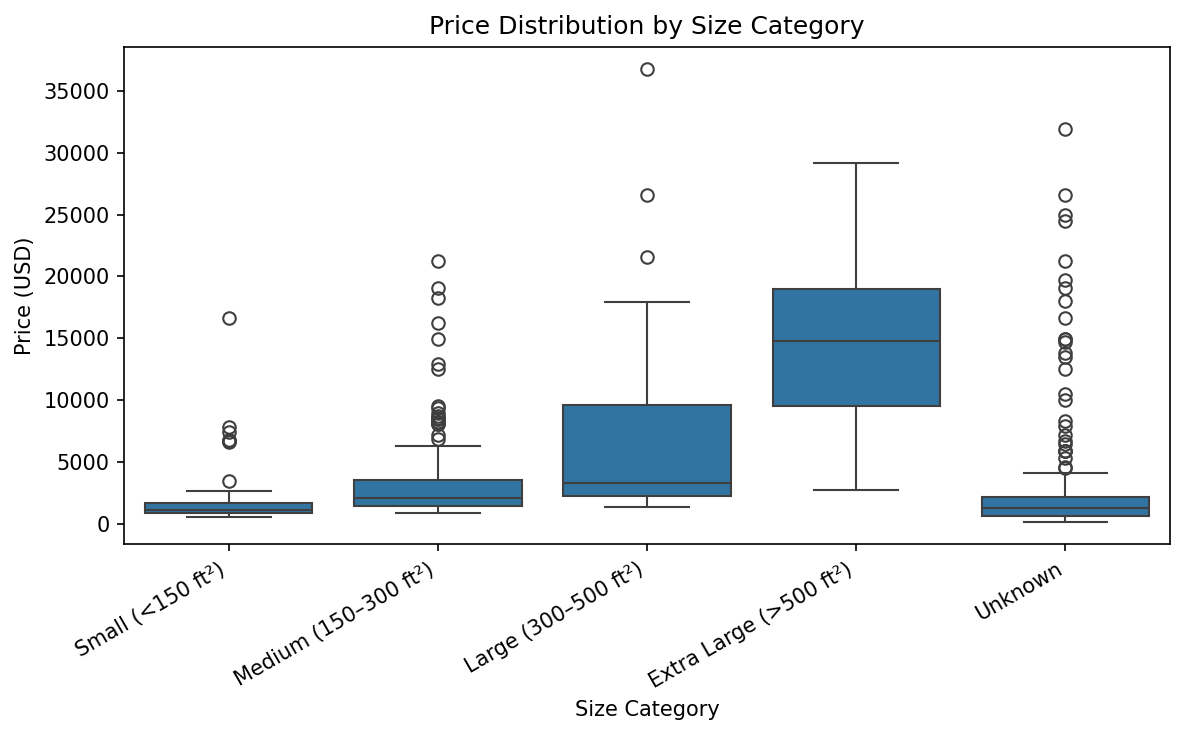

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="Size_Category", y="Price_num", order=["Small (<150 ft²)", "Medium (150–300 ft²)", "Large (300–500 ft²)", "Extra Large (>500 ft²)", "Unknown"])
plt.title("Price Distribution by Size Category")
plt.ylabel("Price (USD)")
plt.xlabel("Size Category")
plt.xticks(rotation = 30, ha = "right")
plt.tight_layout()
plt.show()

* Strong size–price relationship: As tent size increases, so does median price — moving from ＄1,110 (Small) to ＄14,800 (Extra Large).

* Small (<150 ft²) tents have the lowest median price in the dataset, confirming they are the most budget-friendly category.

* Extra Large (>500 ft²) tents are rare (only 11 listings) but have a median price more than 13× higher than Small tents, indicating a highly specialized, premium product segment.

* Large (300–500 ft²) tents have a median of ＄3,273, more than Medium (＄2,130), but the price jump is modest compared to the leap from Large to Extra Large.

* Unknown size category (226 listings) has a median of ＄1,315 — slightly higher than Small, suggesting it may contain a mix of smaller and some mid-sized tents rather than only the smallest category.

In [192]:
# Price per ft² by Size Category

def categorize_area(area):
  if pd.isna(area):
    return "Unknown"
  elif area < 150:
    return "Small (<150 ft²)"
  elif area < 300:
    return "Medium (150–300 ft²)"
  elif area < 500:
    return "Large (300–500 ft²)"
  else:
    return "Extra Large (>500 ft²)"
df["Size_Category"] = df["estimated_area_ft2"].apply(categorize_area)
cat_order = ["Small (<150 ft²)","Medium (150–300 ft²)",
             "Large (300–500 ft²)","Extra Large (>500 ft²)","Unknown"]
df["Size_Category"] = pd.Categorical(df["Size_Category"], categories=cat_order, ordered=True)

ppsf_by_size = (
    df.groupby("Size_Category", observed = True)
      .agg(count=("price_per_ft2","count"),
           median_ppsf=("price_per_ft2","median"),
           mean_ppsf=("price_per_ft2","mean"),
           median_price=("Price_num","median"))
      .reindex(cat_order)
)
ppsf_by_size

,count,median_ppsf,mean_ppsf,median_price
Size_Category,,,,
Small (<150 ft²),108,11.105525,15.557412,1110.5
Medium (150–300 ft²),133,10.029762,16.899738,2130.0
Large (300–500 ft²),78,9.516125,18.145393,3273.0
Extra Large (>500 ft²),11,20.288248,21.748419,14800.0
Unknown,0,NaN,NaN,1315.4


* Extra Large models also have the highest median price per ft² (20.29) — meaning they’re not only the most expensive in absolute terms but also on a per-unit basis, likely due to premium materials, engineering, or niche uses.

* Small, Medium, and Large tents cluster in the ＄9.5–＄11.1 per ft² range, showing little variation in cost efficiency for mid-size categories.

* Large (300–500 ft²) tents are the cheapest per ft² (＄9.51), offering the best relative value despite higher total prices.

* Unknown size tents cannot be evaluated per ft² and may distort averages if included in size-based comparisons.

In [ ]:
# Price vs Feature Relationship


targets = ["Price_num", "price_per_ft2"]
targets = [t for t in targets if t in df.columns]  # keep ones that exist

features = [
    "Maximum Height (ft)_num",
    "Room Capacity_num",
    "Wind Rating_num",
    "Lead Time (in days)_num",
    "Assembly Time (in hours)_num",
    "Estimated Life Span (in years)_num",
    "Return (in days)_num",
    "Warranty (in years)_num",
]
features = [f for f in features if f in df.columns]


def plot_scatter_with_fit(df, x, y, min_n=25, title=None):
    sub = df[[x, y]].copy()
    sub[x] = pd.to_numeric(sub[x], errors="coerce")
    sub[y] = pd.to_numeric(sub[y], errors="coerce")
    sub = sub.replace([np.inf, -np.inf], np.nan).dropna()

    n = len(sub)
    if n == 0:
        return
    plt.figure(figsize=(5.2, 4.0))
    plt.scatter(sub[x], sub[y], s=12, alpha=0.5)

    if n >= min_n and sub[x].nunique() >= 2:

        X = sub[x].to_numpy(dtype=float)
        Y = sub[y].to_numpy(dtype=float)
        m, b = np.polyfit(X, Y, 1)
        xs = np.linspace(X.min(), X.max(), 100)
        ys = m * xs + b
        plt.plot(xs, ys)

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title or f"{y} vs {x} (n={n})")
    plt.tight_layout()
    plt.show()


rows = []
for f in features:
    for t in targets:
        sub = df[[f, t]].copy()
        sub[f] = pd.to_numeric(sub[f], errors="coerce")
        sub[t] = pd.to_numeric(sub[t], errors="coerce")
        sub = sub.replace([np.inf, -np.inf], np.nan).dropna()
        n = len(sub)
        if n >= 3:
            pear = sub[f].corr(sub[t], method="pearson")
            spear = sub[f].corr(sub[t], method="spearman")
        else:
            pear = np.nan
            spear = np.nan
        rows.append([f, t, n, round(pear, 3) if pd.notna(pear) else np.nan,
                          round(spear, 3) if pd.notna(spear) else np.nan])

corr_table = pd.DataFrame(rows, columns=["feature", "target", "n", "pearson_r", "spearman_r"]) \
               .sort_values(["target","pearson_r"], ascending=[True, False])
corr_table


,feature,target,n,pearson_r,spearman_r
12,Return (in days)_num,Price_num,45,0.743,0.834
0,Maximum Height (ft)_num,Price_num,245,0.714,0.740
10,Estimated Life Span (in years)_num,Price_num,32,0.369,0.399
8,Assembly Time (in hours)_num,Price_num,77,0.314,0.483
6,Lead Time (in days)_num,Price_num,151,0.068,0.435
2,Room Capacity_num,Price_num,128,0.031,0.276
4,Wind Rating_num,Price_num,52,0.022,0.013
14,Warranty (in years)_num,Price_num,109,-0.225,-0.167
9,Assembly Time (in hours)_num,price_per_ft2,40,0.679,0.267
1,Maximum Height (ft)_num,price_per_ft2,180,0.583,0.092


In [ ]:
def plot_feature_grid(df, features, target, n_cols=3, title=None, min_n=25):

    corr_info = []
    for f in features:
        if f in df.columns and df[f].notna().sum() >= min_n:
            r = df[[f, target]].dropna().corr(method="pearson").iloc[0, 1]
            corr_info.append((f, r))
    features_sorted = [f for f, _ in sorted(corr_info, key=lambda x: abs(x[1]), reverse=True)]

    # Plot
    n_rows = int(np.ceil(len(features_sorted) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(features_sorted):
        sns.regplot(
            data=df,
            x=feature,
            y=target,
            ax=axes[i],
            scatter_kws={'alpha': 0.6},
            line_kws={'color': 'blue'},
            ci=None
        )
        r_val = df[[feature, target]].dropna().corr(method="pearson").iloc[0, 1]
        axes[i].set_title(f"{feature.replace('_num','')} (r={r_val:.2f})", fontsize=10)
        axes[i].set_xlabel(feature.replace("_num", ""), fontsize=8)
        axes[i].set_ylabel(target.replace("_num", ""), fontsize=8)
        axes[i].grid(True, linestyle='--', alpha=0.5)


    for j in range(len(features_sorted), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


features = [
    "Maximum Height (ft)_num",
    "Room Capacity_num",
    "Wind Rating_num",
    "Snow Load_num",
    "Lead Time (in days)_num",
    "Assembly Time (in hours)_num",
    "Estimated Life Span (in years)_num",
    "Return (in days)_num",
    "Warranty (in years)_num",
    "warranty_main_years",
    "warranty_fabric_years"
]



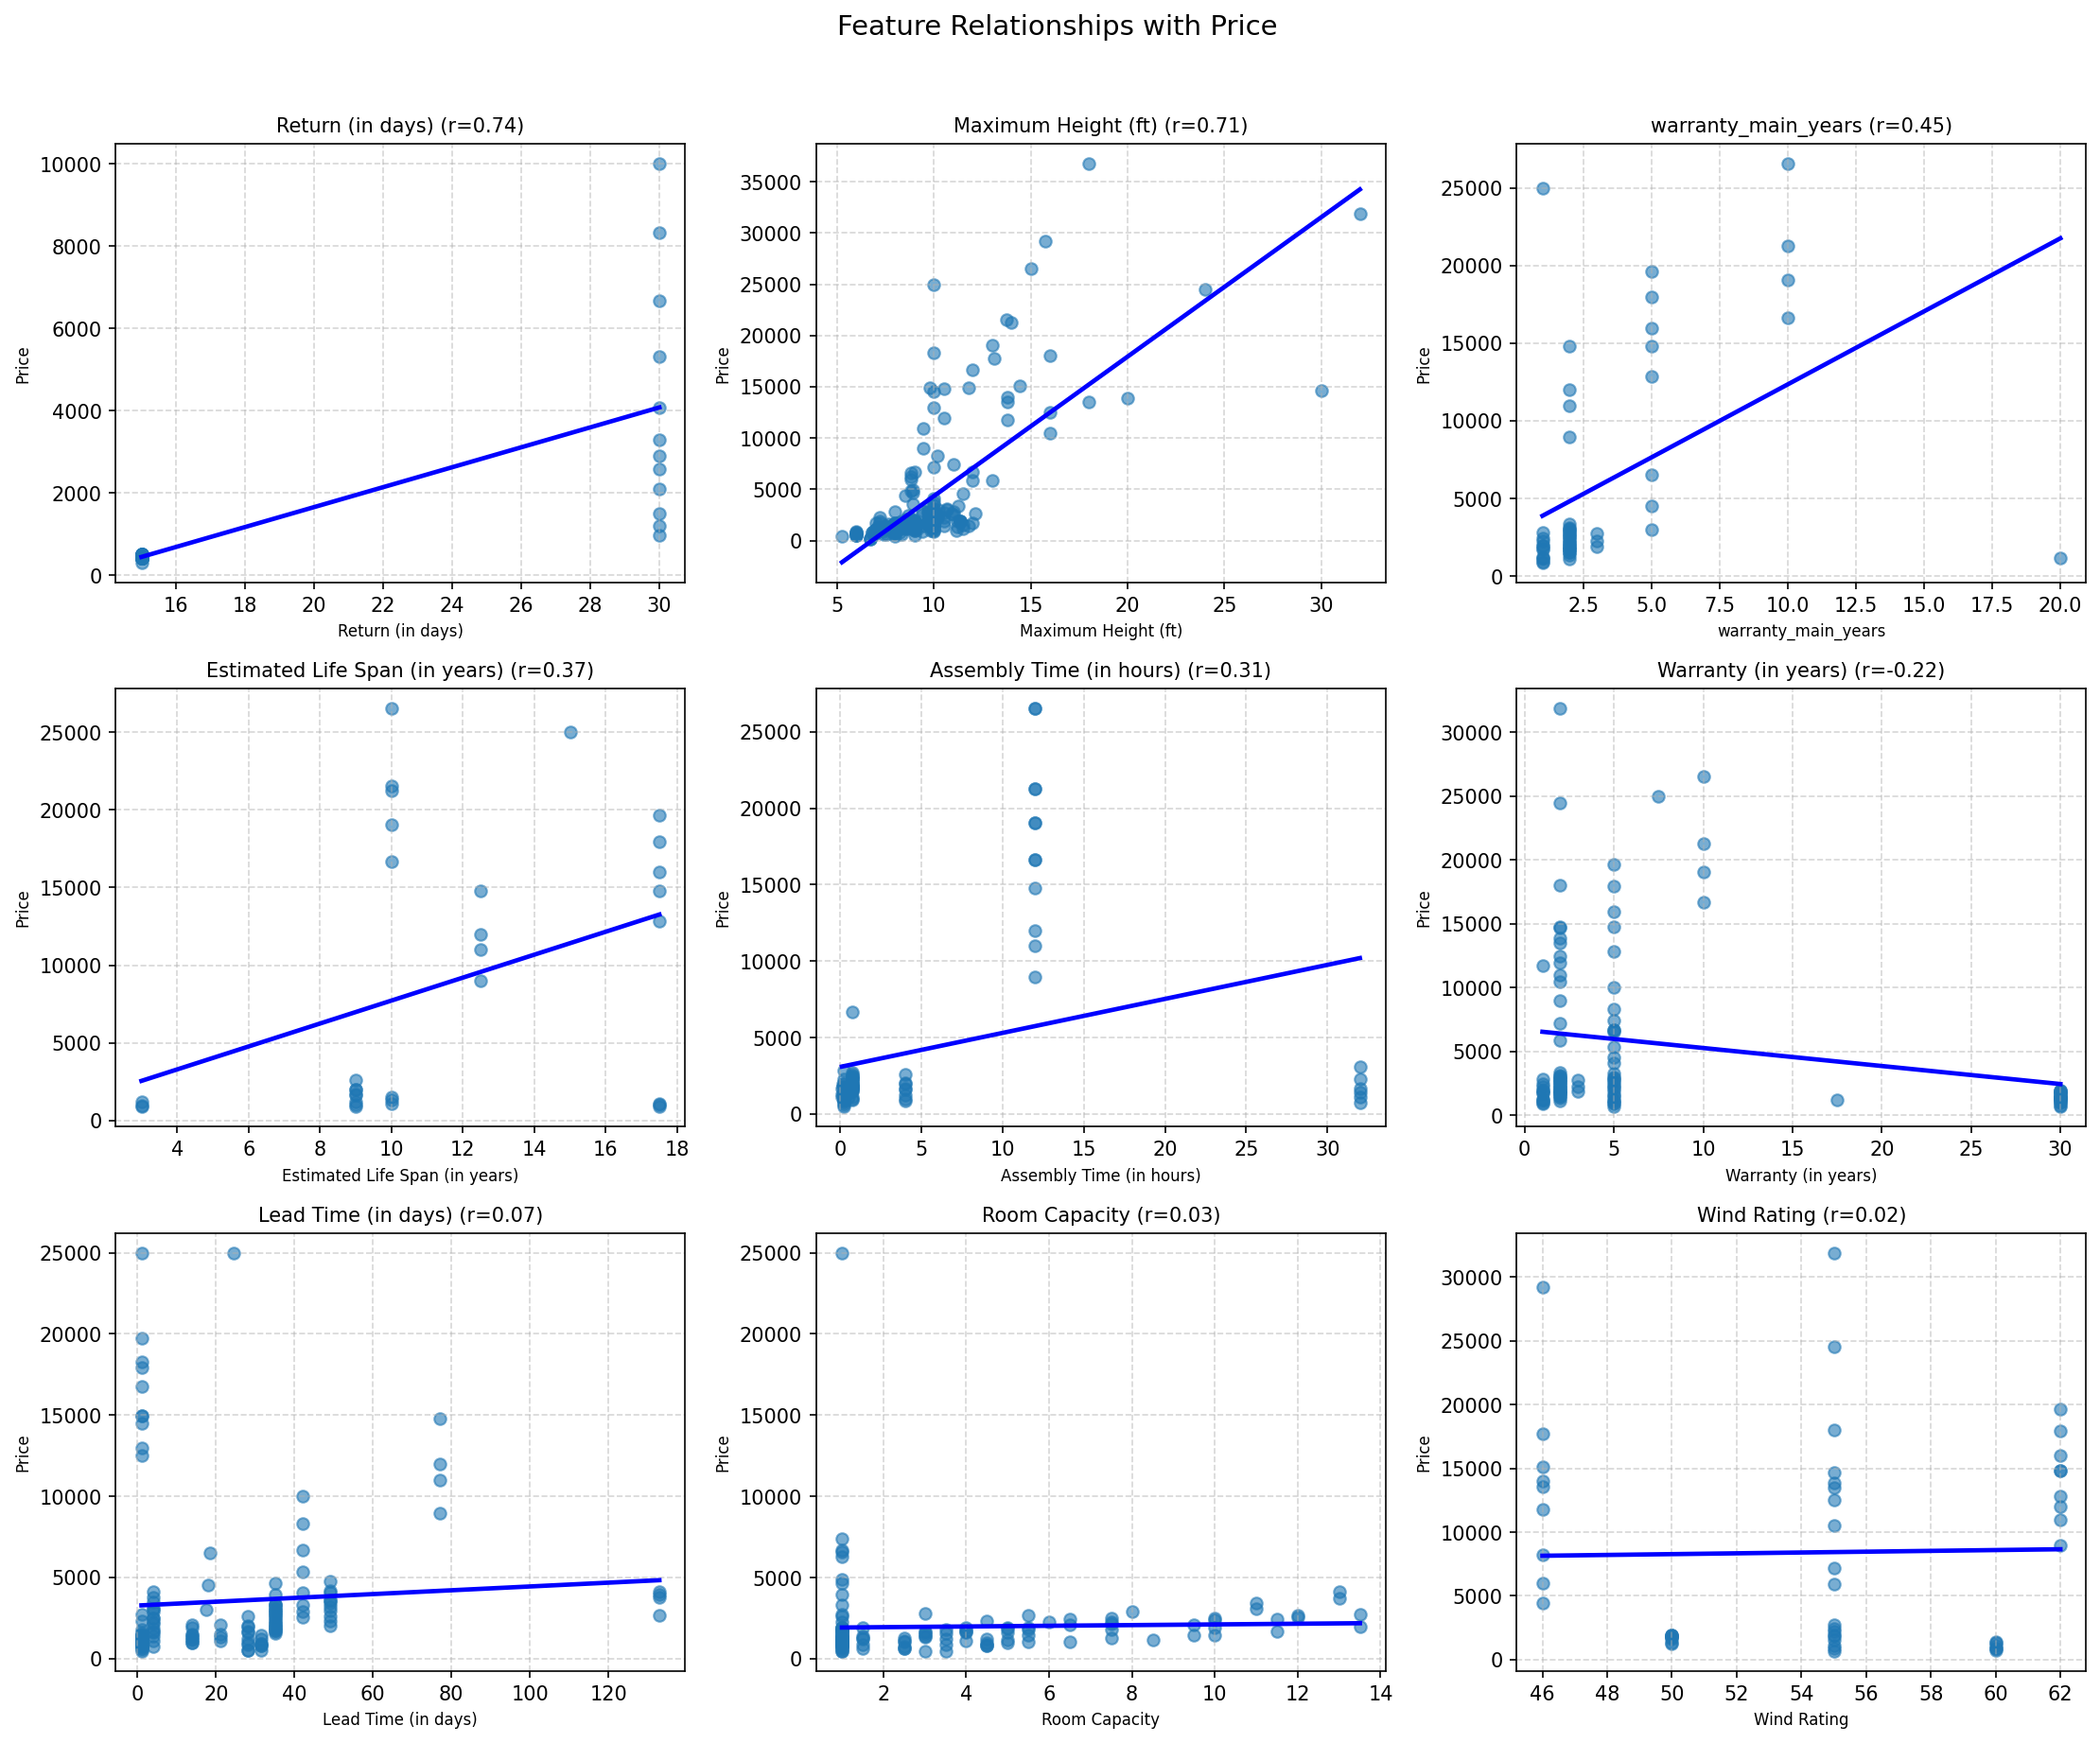

In [ ]:
plot_feature_grid(df, features, "Price_num", n_cols=3, title="Feature Relationships with Price")

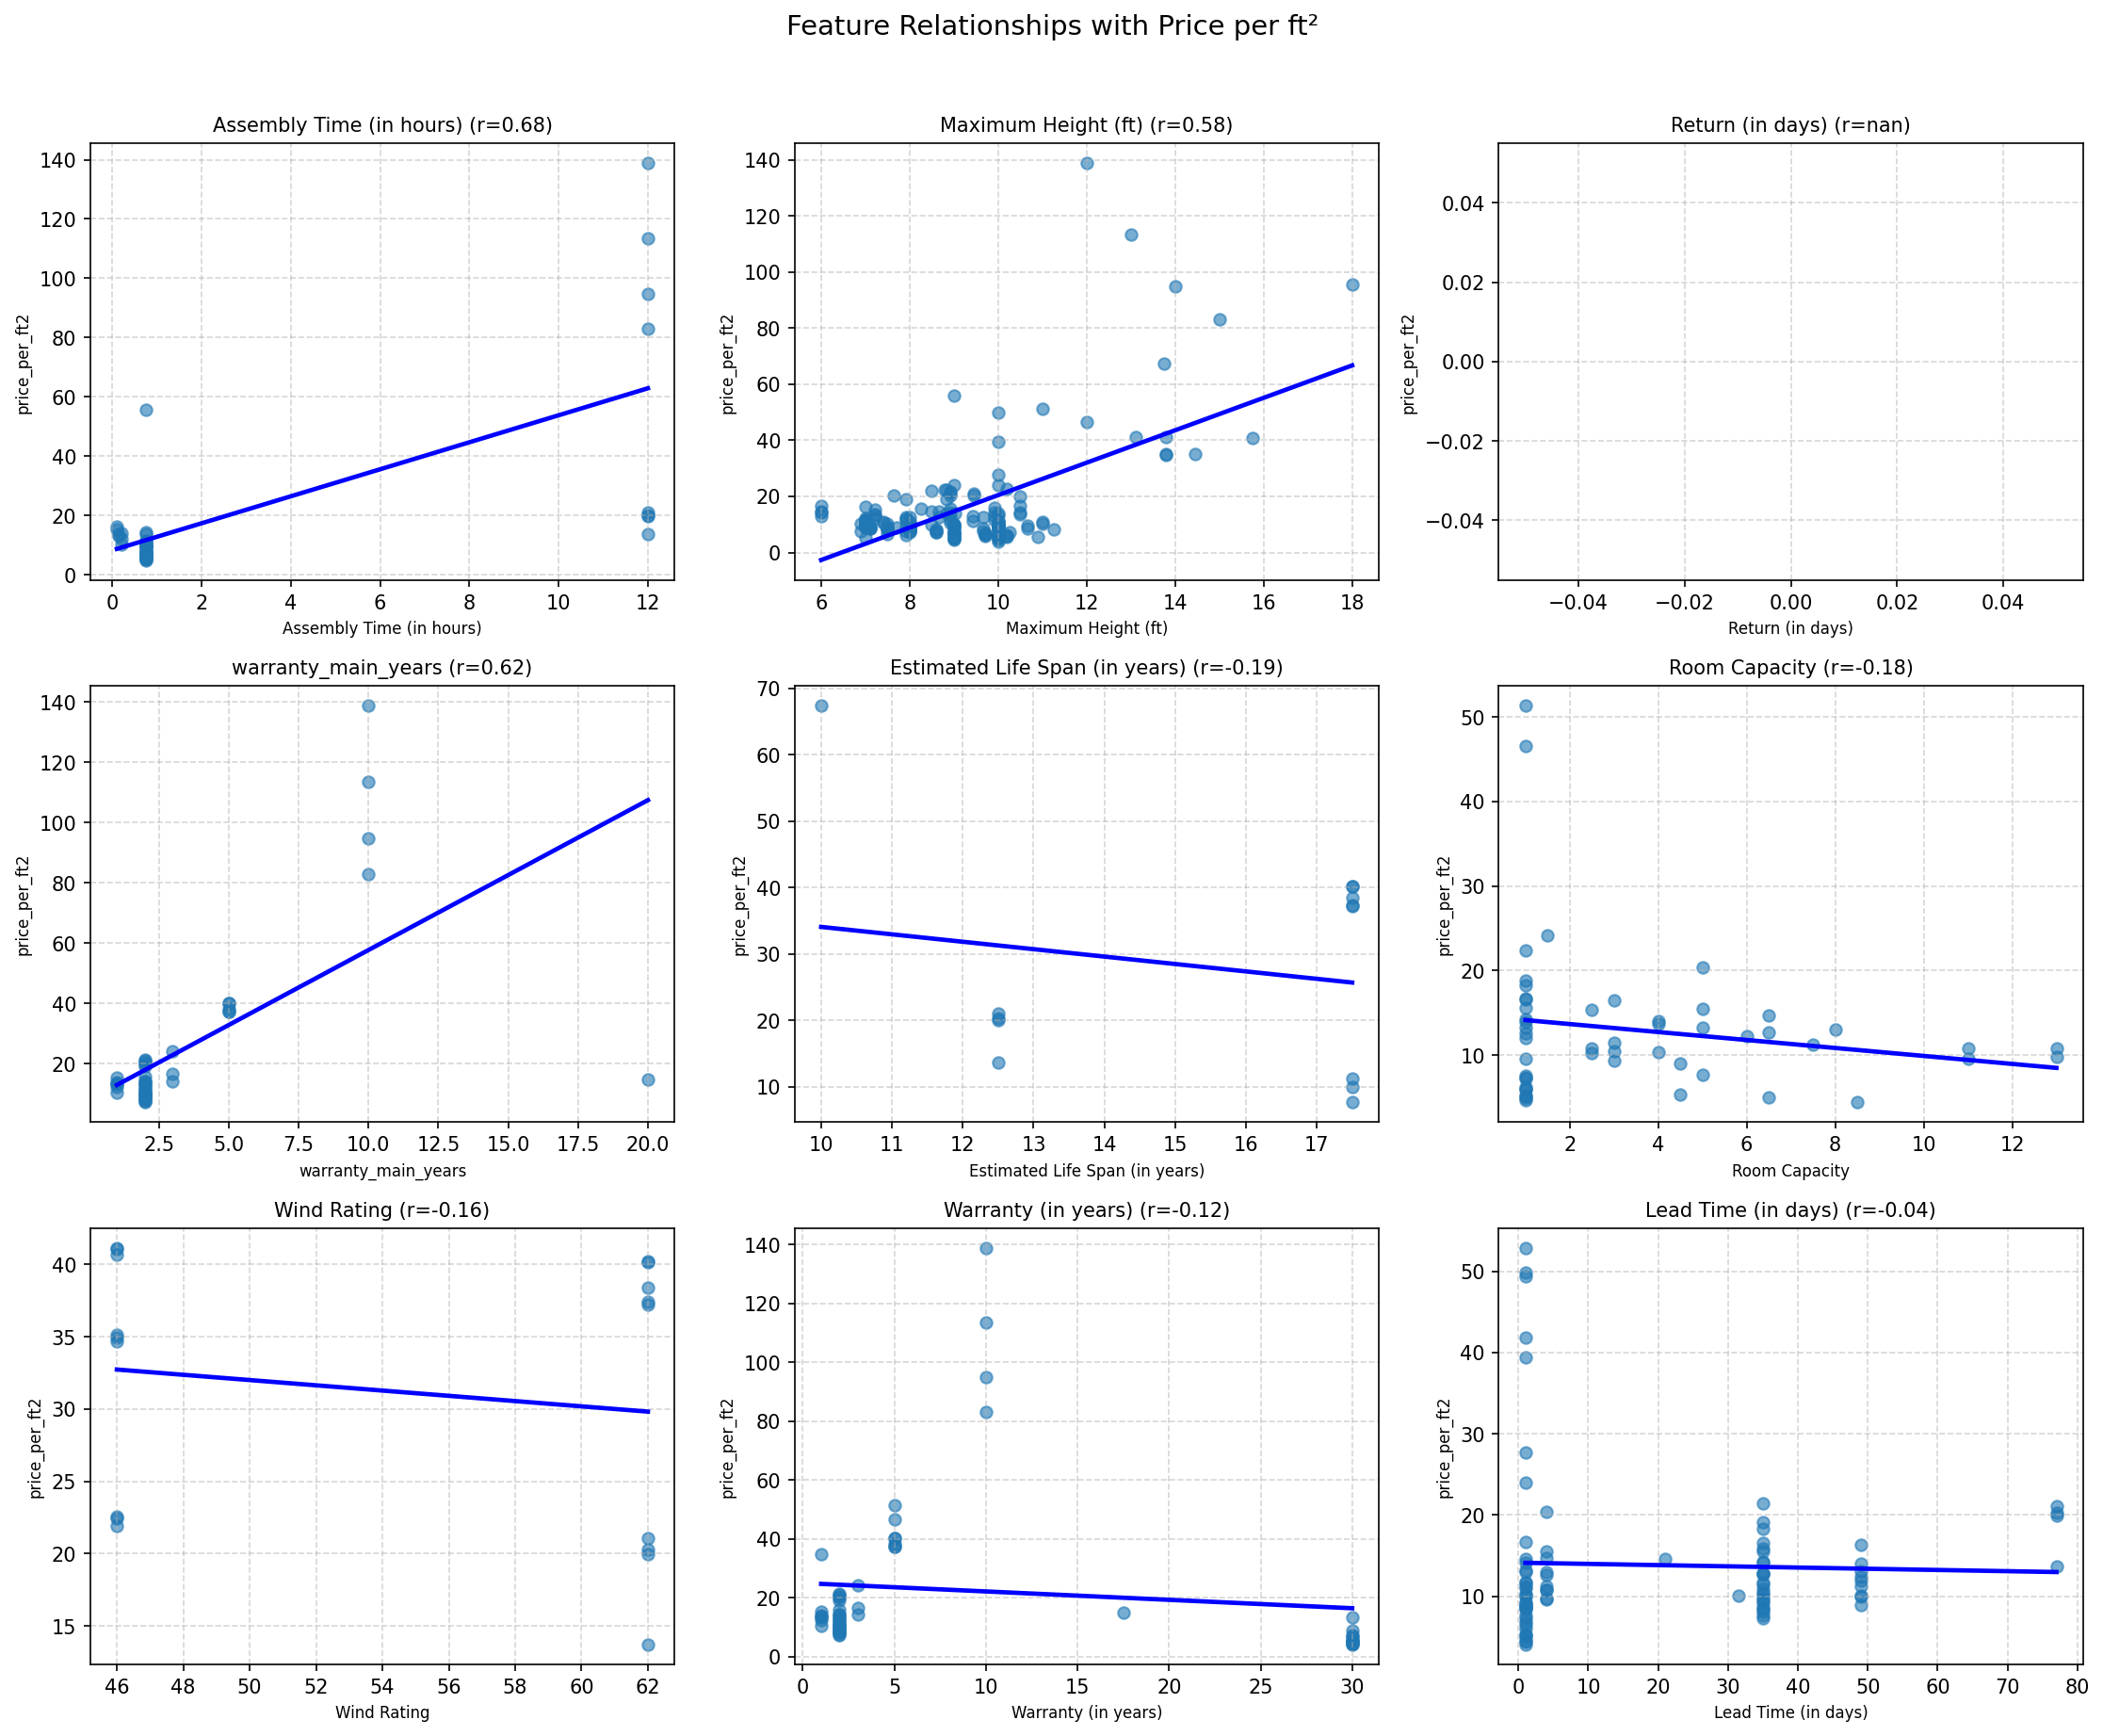

In [ ]:
plot_feature_grid(df, features, "price_per_ft2", n_cols=3, title="Feature Relationships with Price per ft²")

* Return Policy Length is the standout predictor of higher prices —
Strong positive correlation with Price (Pearson 0.743, Spearman 0.834).
This could indicate that higher-priced tents come with more generous return periods, possibly as a signal of quality or confidence.

* Maximum Height matters for both total price and unit price —
High positive correlation with Price (0.714) and moderate with price per ft² (0.583).
Taller designs appear to command a height premium both in absolute and per-area terms.

* Assembly Time shows a moderate link to value-based pricing —
Weak-to-moderate correlation with Price (0.314) but high with price per ft² (0.679).
Tents that take longer to set up may be smaller, complex, or niche — and are priced higher relative to size.

* Estimated Life Span has only a modest positive relationship with Price —
(Pearson 0.369), suggesting durability plays some role but isn’t a primary driver in this dataset (possibly due to missing data).

* Lead Time is mostly unrelated to price, except a mild Spearman rank correlation (0.435) with Price.
This may point to specific higher-priced models having longer wait times, but not consistently.

* Room Capacity, Wind Rating, and Warranty Length show little to no price linkage —In fact, Warranty has a slight negative correlation with Price (−0.225), which might reflect budget tents being marketed with longer nominal warranties as a selling point.

# Summary of Key Insights

**1. Data Quality & Structure**
* Dataset required significant cleaning: ranges (e.g., “8–10 years”), accidental date conversions, and placeholder values (“Not Specified”) were standardized.
* Created numeric versions (*_num) for analysis, enabling correlation and regression checks.
* Missing data is uneven — strong coverage for price and size, but sparse for durability (wind/snow load) and lifespan, which limits certain analyses.

**2. Market Composition**
84% of listings are Wall Tents, Teepees, or Safari Tents, indicating a highly concentrated market.

* Manufacturer market share is fragmented — no single brand exceeds 9% share.
* Most tents are US-based (83%), with Canada as the only other significant source (17%).

**3. Price Levels & Value**
* Prices range from ≈＄180 to ≈＄36.7K, with a median of ≈＄1.69K.
* Price per ft² median is ≈＄8–10, but luxury niche tents can exceed ＄100/ft².
* Safari Tents have the highest PPSF among high-volume categories (≈＄28.74/ft²).
* Wall Tents dominate volume but have the lowest PPSF (≈＄9.18/ft²), making them space-efficient value buys.

**4. Country-Level Differences**
* Median price in Canada is 6.5% higher than in the US; PPSF is 36% higher.
* Within the same tent type, Canadian prices are consistently higher (e.g., Safari Tents: ＄15,130 vs ＄6,900 US).
* This indicates a within-category premium, not a product mix effect — Canada simply charges more for the same types.

**5. Product Type Representation**
* Canada under-represents certain premium categories (e.g., Cocoon, Panorama).
* Over-represents lower-cost categories (Wall Tents, Teepees), but higher within-category prices offset what would normally be a negative mix effect.

**6. Climate & Durability**
* US-only tents have slightly higher snow and wind ratings than shared models, suggesting exclusivity is likely due to demand or supply chain factors rather than climate constraints.

**7. Size-Based Patterns**
* Clear size–price relationship: Small tents median ≈＄1,110; Extra Large median ≈＄14,800.
* Large tents offer the best PPSF value (≈＄9.51) despite higher total prices.
* Extra Large tents are rare but have both the highest absolute prices and highest PPSF.

**8. Correlation Findings**
* Strongest price driver: Return Policy Length (Pearson 0.743).
* Height premium: Maximum Height correlates with both price (0.714) and PPSF (0.583).
* Assembly Time has a strong PPSF correlation (0.679) — complex tents cost more per area.
* Lifespan, lead time, and capacity show weaker or inconsistent relationships with price.

# Recommendations

**1. Standardize Data Collection**
* Enforce structured numeric fields to reduce cleaning needs.
* Capture missing size and durability attributes to improve product comparisons.

**2. Leverage the Canadian Price Premium**
* Explore why Canadian buyers pay more for the same tent types. This could inform pricing strategy in other regions.
* Consider cross-border selling if logistics allow.

**3.Capitalize on High-PPSF Categories**
* Promote Safari Tents and A-Frame Tents in marketing as premium options.
* Position Wall Tents as high-value, space-efficient models for cost-conscious buyers.

**4.Expand Product Range in Canada**
* Introduce under-represented premium types like Cocoon and Panorama to capture higher-margin opportunities.

**5.Refine Size-Based Pricing Strategy**
* Use size segmentation in marketing. Highlight the value of large tents for budget-conscious buyers and premium positioning for extra-large tents.

**6.Highlight Strength and Weather Resilience**
* Even though climate suitability is not a limiting factor, emphasizing higher snow/wind ratings could justify premium pricing.

**7.Investigate Return Policy Impact**
* Longer return periods are linked with higher prices. Offering extended returns could support premium positioning.